#### Análisis y Procesamiento de Señales

---

# Tarea Semanal N°9
## *Filtrado no lineal*

#### Augusto Colugnatti

---

## Introducción teórica

A raíz de la problemática que representa el ruido de baja frecuencia en las señales de ECG, sea en este caso el movimiento de línea de base, se propone realizar una serie de filtrados por metodologías no lineales para su atenuación. A diferencia de los filtros diseñados en tareas anteriores, los cuales cumplían con los principios de linealidad e invarianza temporal, los métodos a utilizar esta vez se caracterizan por no cumplir estas condiciones. Que un sistema viole el principio de linealidad puede derivar en la aparición de nuevas frecuencias (por ejemeplo, armónicos) que no existían en la señal de entrada, pudiendo, del mismo modo, eliminar valores atípicos según la metodología implementada. Mientras que el diseño de los filtros LTI radica en el dominio de las frecuencias, pues se propone una plantilla de diseño a modo de "selectividad", los filtros no lineales se proyectan y trabajan únicamente sobre la topología de la señal, es decir, sobre sus muestras.

El objetivo común de las dos primeras metodologías consiste en estimar y substraer el movimiento de línea de base de, en este caso, una señal de ECG. Como se mencionó en la tarea anterior, este movimiento puede ser generado a raíz de una mal contacto de los electrodos, movimientos del paciente (incluyendo su propia respiración), ruido de baja frecuencia, etc. A continuación se desarrollan, conceptualmente, los procedimientos a utilizar.

→ **Filtro de mediana**

El operador de **mediana** es una función estadística que toma una cantidad establecida **w** de muestras, las reordena en forma creciente o decreciente (resulta indistinto), y toma su valor medio. Este proceso se implementa de manera algortítmica y se ejectua muestra a muestra, pensar en que se desplaza suavemente al operador a lo largo de toda la señal. Como resultado, se obtiene una secuencia que preserva los cambios lentos (movimientos de baja frecuencia) y tiende a anular los cambios rápidos (movimientos de alta frecuencia), actuando como un filtro pasa-bajos que estimará la línea base. Para que cada iteración tenga un único valor central, se le asigna a **w** valores impares.

\begin{equation}
\hat{b} = \underset{601}{med} \left(\underset{201}{med}(s) \right)
\end{equation}

Observar que se utiliza primeramente una ventana de 201 muestras (en este caso 200ms, pues se muestreó a 1000Hz) para filtrar el ruido generado por el complejo QRS, para luego aplicar otra mayor, de 601 muestras (600ms), que barra las interferencias residuales. Por último, se substrae el movimiento estimado de la señal mediante la siguiente operación:

\begin{equation}
\hat{x} = s - \hat{b}
\end{equation}

... siendo $s$ la señal original de ECG, y $\hat{x}$ el resultado de haber filtrado su movimiento de línea base.

→ **Interpolación por Splines Cúbicos**

La interpolación por **splines cúbicos** consiste en una técnica que busca unir una secuencia de puntos dados mediante, en este caso, polinomios de tercer grado, lo que garantiza continuidad y suavidad en toda su curvatura. La secuencia de puntos a interpolar será aquella que siga, o aproxime, el movimiento de línea base. El criterio supone ubicar dichos puntos sobre el segmento PQ, pues en él se estima el menor nivel isoeléctrico del latido. Sin embargo, es justo allí donde se pueden encontrar otro tipo de interferencias, como las de 50Hz, que obedecen a la frecuencia de la red eléctrica a la que está conectada el equipo. Para evitar esto, en lugar de tomar un valor arbitrario dentro del segmento, se promediarán los 100ms (duración aproximada del periodo PQ) tomando ventanas de 20ms. Observar que se toma un valor que no coincida con múltiplos de la frecuencia de red (50Hz), y menor a esta, para que el promediado reduzca esos cambios rápidos de alta frecuencia. Como resultado, se obtiene una estimación $\hat{b}$ de la línea base interpolada, que luego será substraída de la ECG del mismo modo que en la técnica anterior.

→ **Filtro adaptado**

Este método se utiliza para la detección de un patrón dado a lo largo de toda una señal. En este caso, dada la señal de ECG, se busca obtener una detección de todos sus latidos. Para ello, se la correlaciona en forma cruzada con la secuencia de un latido típico (en la práctica se utiliza una herramienta de diseño de filtros FIR). Como resultado se obtiene una señal cuyos picos identifican a las regiones de máxima concordancia, y por lo tanto, a los latidos. Por el contrario, allí donde haya nula o poca similitud, sus valores serán mínimos, atenuando toda interferencia no correlada. 

---

## Desarrollo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from numpy.fft import fft
import scipy.signal as sp
import scipy.signal.windows as window
import scipy.stats as st
import scipy.io as sio
import scipy.interpolate as interpol
# from pytc2.sistemas_lineales import plot_plantilla

def matriz_confusion_qrs (mis_qrs, qrs_det, tolerancia_ms=150, fs=1000):
    
    """
    Calcula matriz de confusión para detecciones QRS usando solo NumPy y SciPy
    
    Parámetros:
    - mis_qrs: array con tiempos de tus detecciones (muestras)
    - qrs_det: array con tiempos de referencia (muestras)  
    - tolerancia_ms: tolerancia en milisegundos (default 150ms)
    - fs: frecuencia de muestreo (default 360 Hz)
    """
    
    # Convertir a arrays numpy
    mis_qrs = np.array(mis_qrs)
    qrs_det = np.array(qrs_det)
    
    # Convertir tolerancia a muestras
    tolerancia_muestras = tolerancia_ms * fs / 1000
    
    # Inicializar contadores
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    
    # Arrays para marcar detecciones ya emparejadas
    mis_qrs_emparejados = np.zeros(len(mis_qrs), dtype=bool)
    qrs_det_emparejados = np.zeros(len(qrs_det), dtype=bool)
    
    # Encontrar True Positives (detecciones que coinciden dentro de la tolerancia)
    for i, det in enumerate(mis_qrs):
        diferencias = np.abs(qrs_det - det)
        min_diff_idx = np.argmin(diferencias)
        min_diff = diferencias[min_diff_idx]
        
        if min_diff <= tolerancia_muestras and not qrs_det_emparejados[min_diff_idx]:
            TP += 1
            mis_qrs_emparejados[i] = True
            qrs_det_emparejados[min_diff_idx] = True
    
    # False Positives (tus detecciones no emparejadas)
    FP = np.sum(~mis_qrs_emparejados)
    FP_index = np.where(~mis_qrs_emparejados)[0]
    TP_index = np.where(mis_qrs_emparejados)[0]
    
    # False Negatives (detecciones de referencia no emparejadas)
    FN = np.sum(~qrs_det_emparejados)
    FN_index = np.where(~qrs_det_emparejados)[0]
    
    # Construir matriz de confusión
    matriz = np.array([
        [TP, FP],
        [FN, 0]  # TN generalmente no aplica en detección de eventos
    ])
    
    return matriz, TP, FP, FN, FP_index, FN_index, TP_index

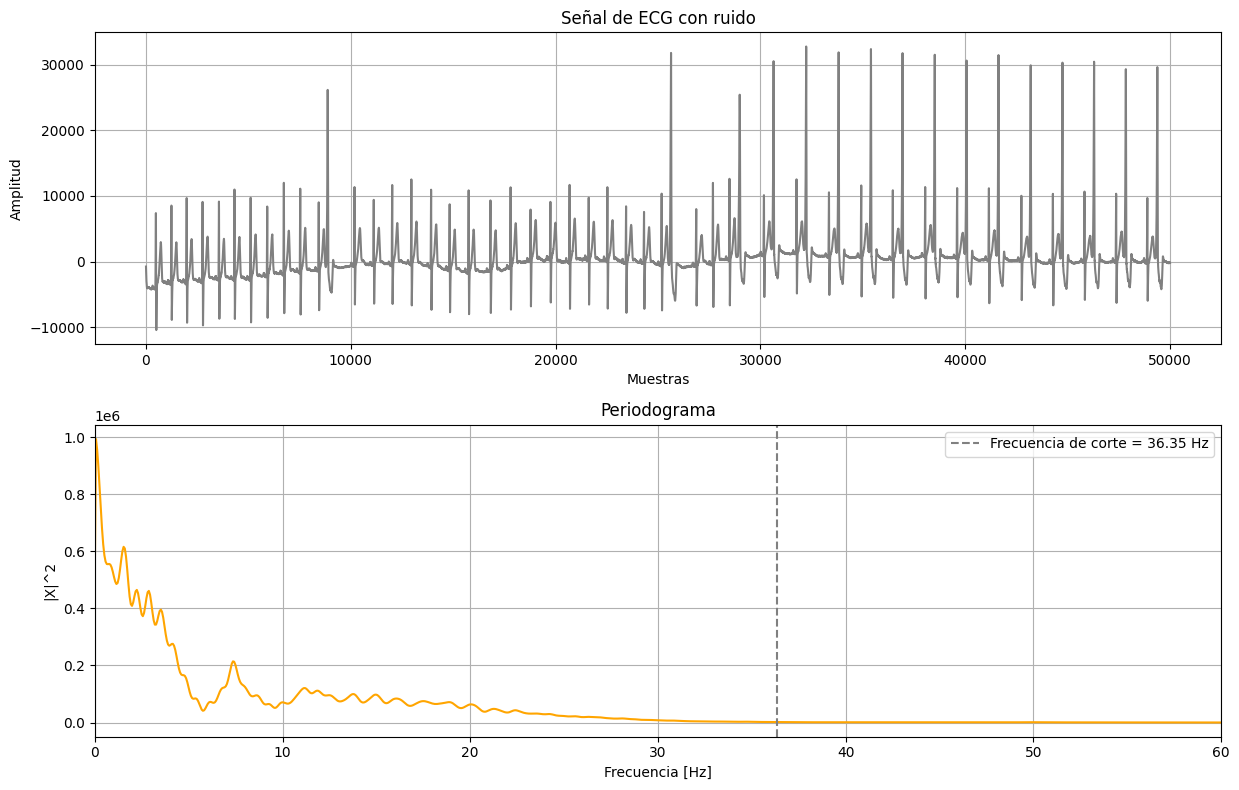

In [2]:
# ------------------------------- Señal de ECG con ruido ------------------------------- #

fs_ECG = 1000

# ECG = sio.whosmat ('./ECG_TP4.mat') # devuelve una lista de variables dentro del archivo .mat (MATLAB)
mat_struct = sio.loadmat ('./ECG_TP4.mat')
# print("Variables encontradas en el archivo .mat:", mat_struct.keys()) # esto muestra las variables dentro del archivo .mat (lo miro desde el explorador de variables)

ecg_one_lead = mat_struct ['ecg_lead'].ravel() # ECG con ruido

hb_1 = mat_struct['heartbeat_pattern1']
hb_2 = mat_struct['heartbeat_pattern2']

ECG_cr = ecg_one_lead[0:50000].ravel()

N_ECG_cr = len (ECG_cr)

df_ECG_cr = fs_ECG / N_ECG_cr
nn_ECG_cr = np.arange (N_ECG_cr)

promedios_ECG_cr = 16
nperseg_ECG_cr = N_ECG_cr // promedios_ECG_cr

ff_ECG_cr, per_ECG_cr = sp.welch (ECG_cr, nfft = 5*nperseg_ECG_cr, fs = fs_ECG, nperseg = nperseg_ECG_cr, window = 'flattop')

energia_acum_cr = np.cumsum (per_ECG_cr)
energia_acum_cr_norm = energia_acum_cr / energia_acum_cr[-1]
corte_ECG_cr = energia_acum_cr_norm[-1] * 0.995
indice_corte_cr = int (np.where (energia_acum_cr_norm >= corte_ECG_cr)[0][0])
frec_corte_cr = ff_ECG_cr[indice_corte_cr]

plt.figure (figsize=(12.5, 8))

plt.subplot (2, 1, 1)
plt.plot (nn_ECG_cr, ECG_cr, color='gray')
# plt.plot (ff_ECG_cr, 10*np.log10(np.abs(per_ECG_cr))) # representación en dB
plt.title ("Señal de ECG con ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_ECG_cr, per_ECG_cr, color='orange')
plt.axvline (frec_corte_cr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_cr:.2f} Hz')
plt.title ("Periodograma")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 60)

plt.tight_layout()
plt.show()

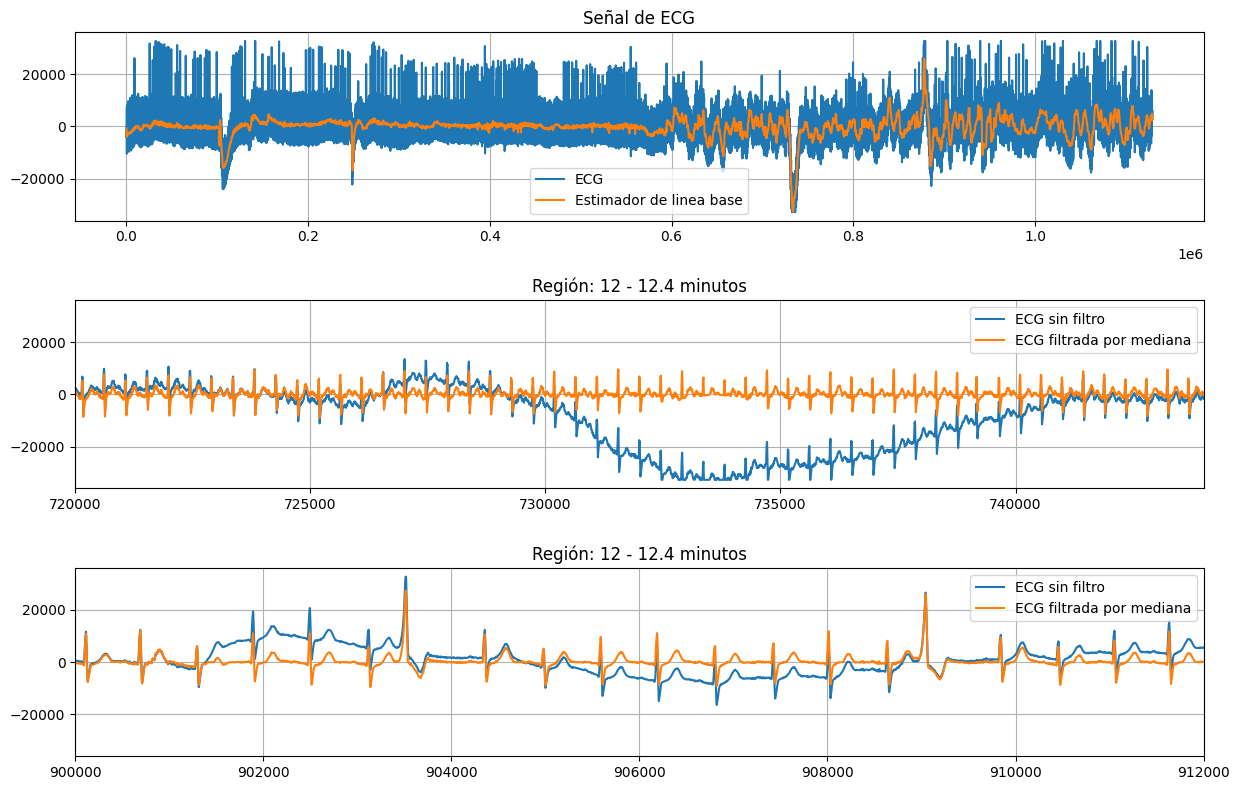

In [17]:
# ------------------------------------- Estimación por mediana ------------------------------------- #

estimador_med = sig.medfilt (sig.medfilt (ecg_one_lead, 201), 601)
ecg_estimada_med = ecg_one_lead - estimador_med

plt.figure (figsize = (12.5, 8))

plt.subplot (3, 1, 1)
plt.plot (ecg_one_lead, label='ECG')
plt.plot (estimador_med, label='Estimador de linea base')
plt.title ('Señal de ECG')
plt.legend ()
plt.grid (True)

plt.subplot (3, 1, 2)
plt.plot (ecg_one_lead, label='ECG sin filtro')
plt.plot (ecg_estimada_med, label='ECG filtrada por mediana')
plt.title ('Región: 12 - 12.4 minutos')
plt.xlim (720000, 744000)
plt.legend ()
plt.grid (True)

plt.subplot (3, 1, 3)
plt.plot (ecg_one_lead, label='ECG sin filtro')
plt.plot (ecg_estimada_med, label='ECG filtrada por mediana')
plt.title ('Región: 12 - 12.4 minutos')
plt.xlim (900000, 912000)
plt.legend ()
plt.grid (True)

plt.tight_layout ()
plt.show ()

# todo artefacto producido por la NO LINEALIDAD (como las discontinuidades, picos) generan ensanchamiento del
# ancho de banda, y puede contaminar a la señal con energía en frecuencias que antes no tenían energía 

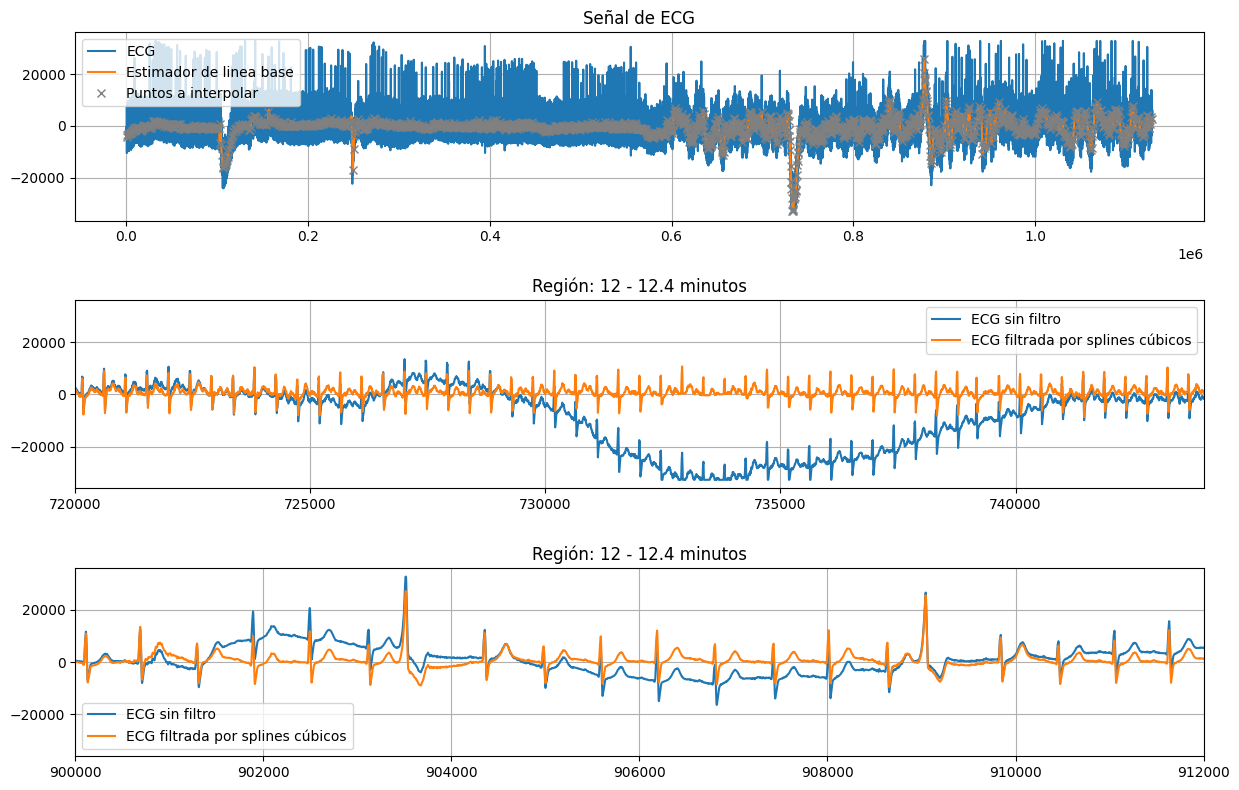

In [16]:
# ------------------------------------- Estimación por Splines Cúbicos ------------------------------------- #

qrs_x = mat_struct ['qrs_detections'].flatten() - 80
qrs_y = ecg_one_lead[qrs_x]

estimador_cs = interpol.CubicSpline (x = qrs_x, y = qrs_y)
ecg_estimada_cs = ecg_one_lead - estimador_cs(np.arange(len(ecg_one_lead)))

plt.figure (figsize = (12.5, 8))

plt.subplot (3, 1, 1)
plt.plot (ecg_one_lead, label='ECG')
plt.plot (estimador_cs(np.arange(len(ecg_one_lead))), label='Estimador de linea base')
plt.plot (qrs_x, qrs_y, marker='x', ls='', color='gray', label='Puntos a interpolar')
plt.title ('Señal de ECG')
plt.legend ()
plt.grid (True)

plt.subplot (3, 1, 2)
plt.plot (ecg_one_lead, label='ECG sin filtro')
plt.plot (ecg_estimada_cs, label='ECG filtrada por splines cúbicos')
plt.title ('Región: 12 - 12.4 minutos')
plt.xlim (720000, 744000)
plt.legend ()
plt.grid (True)

plt.subplot (3, 1, 3)
plt.plot (ecg_one_lead, label='ECG sin filtro')
plt.plot (ecg_estimada_cs, label='ECG filtrada por splines cúbicos')
plt.title ('Región: 12 - 12.4 minutos')
plt.xlim (900000, 912000)
plt.legend ()
plt.grid (True)

plt.tight_layout ()
plt.show ()

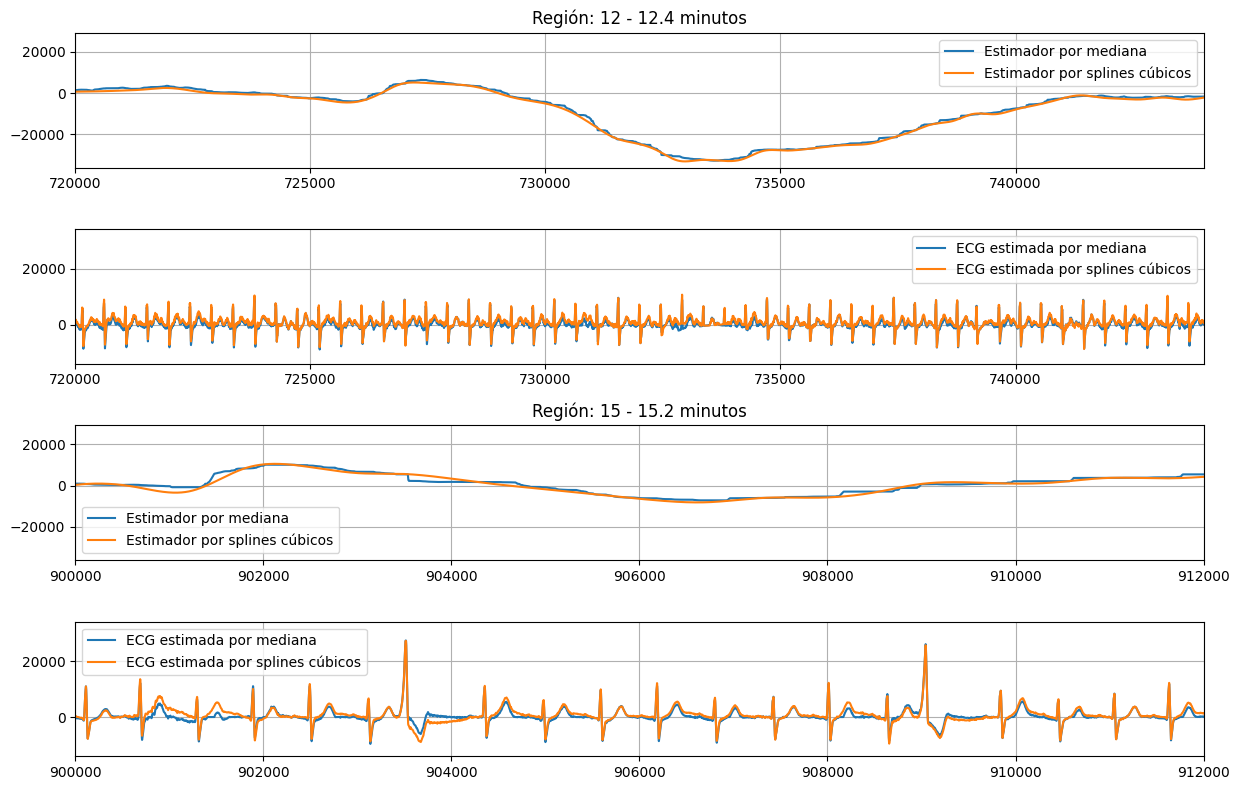

In [12]:
# ------------------------------------- Comparación de estimaciones ------------------------------------- #

plt.figure (figsize = (12.5, 8))

plt.subplot (4, 1, 1)
plt.plot (estimador_med, label='Estimador por mediana')
plt.plot (estimador_cs(np.arange(len(ecg_one_lead))), label='Estimador por splines cúbicos')
plt.title ('Región: 12 - 12.4 minutos')
plt.xlim (720000, 744000)
plt.legend ()
plt.grid (True)

plt.subplot (4, 1, 2)
plt.plot (ecg_estimada_med, label='ECG estimada por mediana')
plt.plot (ecg_estimada_cs, label='ECG estimada por splines cúbicos')
plt.xlim (720000, 744000)
plt.legend ()
plt.grid (True)

plt.subplot (4, 1, 3)
plt.plot (estimador_med, label='Estimador por mediana')
plt.plot (estimador_cs(np.arange(len(ecg_one_lead))), label='Estimador por splines cúbicos')
plt.title ('Región: 15 - 15.2 minutos')
plt.xlim (900000, 912000)
plt.legend ()
plt.grid (True)

plt.subplot (4, 1, 4)
plt.plot (ecg_estimada_med, label='ECG estimada por mediana')
plt.plot (ecg_estimada_cs, label='ECG estimada por splines cúbicos')
plt.xlim (900000, 912000)
plt.legend ()
plt.grid (True)

plt.tight_layout ()
plt.show ()

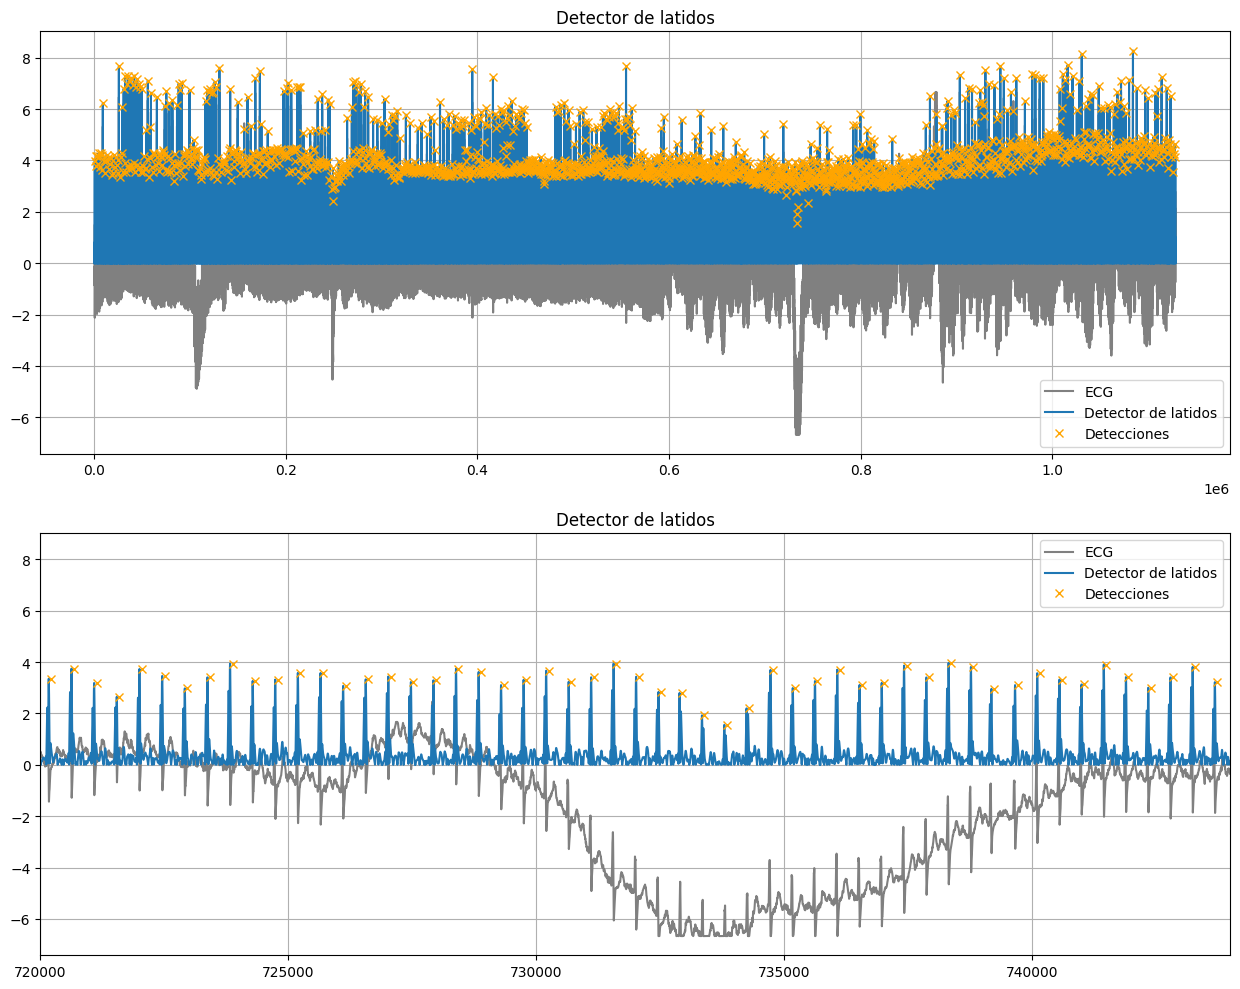

In [19]:
# ------------------------------------- Filtro adaptado ------------------------------------- #

det_ref = mat_struct ['qrs_detections'].ravel()

qrs_patt = mat_struct ['qrs_pattern1'].flatten()
qrs_patt = qrs_patt - np.mean(qrs_patt) # resto el valor medio para que tenga area neta nula, patron centrado en 0

ecg_norm = ecg_one_lead / np.std(ecg_one_lead)
# para que la varianza de una señal sea unitaria, debo escalar por el desvío estándar, esto se hace cuando quiero comparar dos señales de potencias muy diferidas

pulse_detect = sig.lfilter (b = qrs_patt, a = [1], x = ecg_one_lead.astype(np.float64)) # lfilter en el fondo convoluciona las señales, es similar a correlacionarlas
pulse_detect_norm = np.abs(pulse_detect) / np.std(pulse_detect)

beats, _ = sp.find_peaks (x = pulse_detect_norm, height = 1, distance = 300)

plt.figure (figsize=(12.5, 8))

plt.subplot (2, 1, 1)
plt.plot (ecg_norm, color='gray', label='ECG')
plt.plot (pulse_detect_norm[50:], label='Detector de latidos') # con [50:] adelanto/retraso la señal para compensar la demora y alinearla con la ECG
plt.plot (beats, pulse_detect_norm[beats], ls='', marker='x', color='orange', label='Detecciones')
plt.title ('Detector de latidos')
plt.grid (True)
plt.legend ()

plt.subplot (2, 1, 2)
plt.plot (ecg_norm, color='gray', label='ECG')
plt.plot (pulse_detect_norm[50:], label='Detector de latidos') # con [50:] adelanto/retraso la señal para compensar la demora y alinearla con la ECG
plt.plot (beats, pulse_detect_norm[beats], ls='', marker='x', color='orange', label='Detecciones')
plt.title ('Detector de latidos')
plt.xlim (720000, 744000)
plt.grid (True)
plt.legend ()

plt.tight_layout ()
plt.show ()


------- Matriz de Confusión -------
           Detectado
           Sí    No
Real Sí:  [1902   1]
Real No:  [ 2     -]

TP: 1902, FP: 2, FN: 1
-----------------------------------

-------- Métricas --------
Precisión: 0.9989
Sensibilidad: 0.9995
F1-score: 0.9992
--------------------------


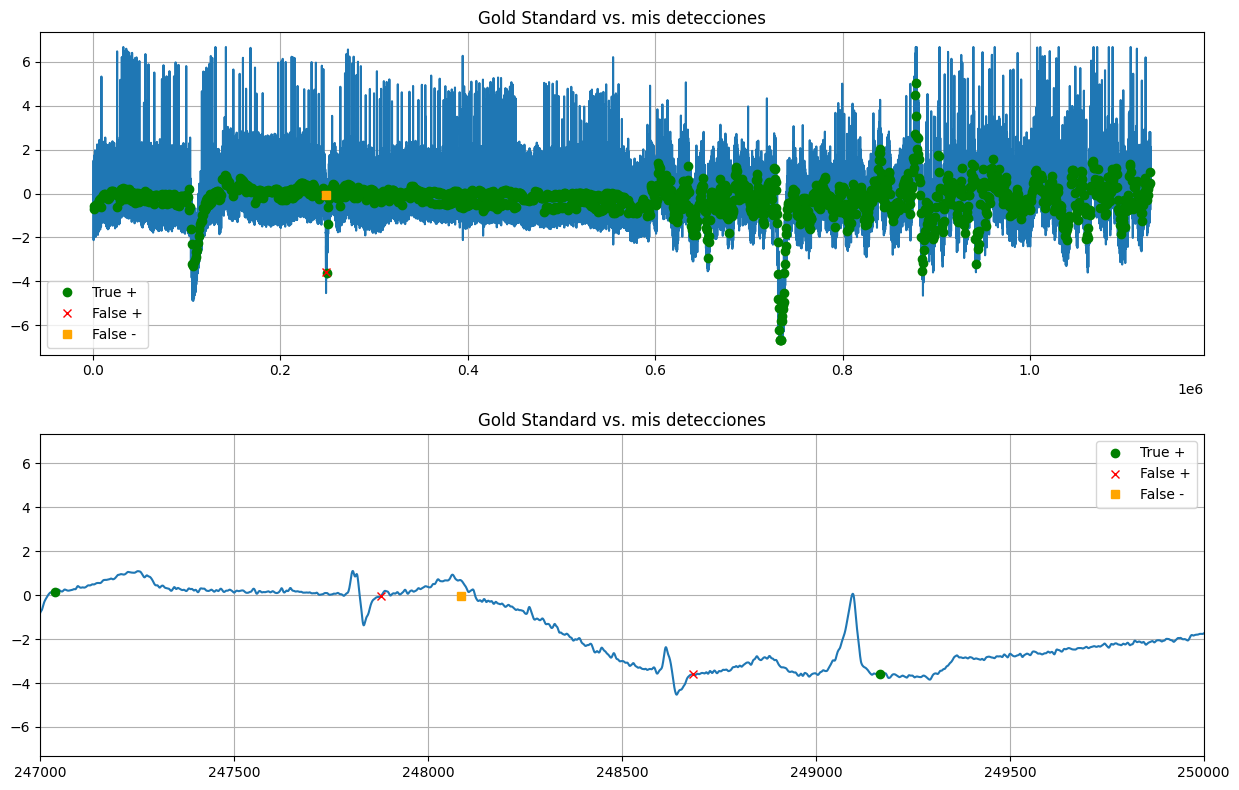

In [21]:
mat_confusion, tp, fp, fn, fp_idx, fn_idx, tp_idx = matriz_confusion_qrs (mis_qrs = beats, qrs_det = det_ref)

# TP (true positive) -> valores que estaban en el gold standard (det_ref) y mi detector encontró
# FP (false positive) -> valores que NO estaban en el gold standard pero detecté erroneamente
# FN (false negative) -> valores que detecté y NO estaban en el gold standard

print("\n------- Matriz de Confusión -------")
print(f"           Detectado")
print(f"           Sí    No")
print(f"Real Sí:  [{tp:2d}  {fn:2d}]")
print(f"Real No:  [{fp:2d}     -]")
print(f"\nTP: {tp}, FP: {fp}, FN: {fn}")
print("-----------------------------------")

# Calcular métricas de performance
if tp + fp > 0:
    precision = tp / (tp + fp) # la precisión mide el cociente entre mis detecciones acertadas y mis detecciones totales
else:
    precision = 0

if tp + fn > 0:
    recall = tp / (tp + fn) # o sensibilidad, mide el cociente entre mis detecciones acertadas y la totalidad de latidos (según gold standar)
else:
    recall = 0

if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall) # punto medio entre precisión y recall ponderado por el de menor valor
else:
    f1_score = 0

print("\n-------- Métricas --------")
print(f"Precisión: {precision:.4f}")
print(f"Sensibilidad: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print("--------------------------")

plt.figure (figsize=(12.5, 8))

plt.subplot (2, 1, 1)
plt.plot (ecg_norm)
plt.plot (beats[tp_idx], ecg_norm[beats[tp_idx]], ls='', marker='o', color='green', label='True +')
plt.plot (beats[fp_idx], ecg_norm[beats[fp_idx]], ls='', marker='x', color='red', label='False +')
plt.plot (det_ref[fn_idx], ecg_norm[beats[fn_idx]], ls='', marker='s', color='orange', label='False -')
plt.title ('Gold Standard vs. mis detecciones')
plt.grid (True)
plt.legend ()

plt.subplot (2, 1, 2)
plt.plot (ecg_norm)
plt.plot (beats[tp_idx], ecg_norm[beats[tp_idx]], ls='', marker='o', color='green', label='True +')
plt.plot (beats[fp_idx], ecg_norm[beats[fp_idx]], ls='', marker='x', color='red', label='False +')
plt.plot (det_ref[fn_idx], ecg_norm[beats[fn_idx]], ls='', marker='s', color='orange', label='False -')
plt.title ('Gold Standard vs. mis detecciones')
plt.xlim (247000, 250000)
plt.grid (True)
plt.legend ()

plt.tight_layout ()
plt.show ()

---

## Conclusiones

En cuanto a la detección y substracción del movimiento de línea de base, tanto el método de mediana como la interpolación por splines cúbicos demostraron gran eficiencia. Se analizaron las regiones que van desde las 720000 a 744000 muestras, y 900000 a 912000 muestras, pues se determina en ellas una presencia considerable de este movimiento de baja frecuencia. Comparando las propias estimaciones $\hat{b}$, se observa que $\hat{b}_{med}$ presenta un movimiento escalonado, pues el operador de mediana variará en forma más abrupta donde la ECG no se comporte suavemente, mientras que $\hat{b}_{cs}$, por la propia naturaleza de los splines de tercer orden, presenta un movimiento suave en toda la estimación, incluso en sus cambios de concavidad. Por otro lado, cabe destacar que el filtro de mediana es aplicable de forma independiente a la señal, requiriendo como único parámetro el tamaño de la ventana con la que va a operar. Sin embargo, la técnica de interpolación por splines, sean del orden que sean, requiere una etapa previa que implica la detección o estimación de los nudos a interpolar, tarea que puede resultar de una complejidad a considerar.

Siguiendo con la tercer metodología implementada, el filtro adaptado permitió obtener una señal carente de movimiento de línea de base. A su vez, pudiéndose pensar como una correlación cruzada entre el patrón de un complejo QRS típico y la señal de ECG, resultó ser una herramienta eficiente para la detección de latidos, pues allí donde este resultado presente valores máximos, será también donde exista una mayor similitud entre ambos. Con el objetivo de evaluar el rendimiento del algoritmo, se obtuvo una matriz de confusión a partir de mis detecciones y las, en teoría, más confiables brindadas por el *Gold Standard*. Como resultado, se obtuvieron:

→ **1902 TP** (verdaderos positivos), es decir, latidos reales detectados por mi algoritmo

→ **2 FP** (falsos positivos), latidos detectados erroneamente por mi algoritmo

→ **1 FN** (falso negativo), aquellos latidos detectados pero no indicados por el *Gold Standard*

A partir de estos valores, se pueden calcular las métricas de mi algoritmo, es decir, su **precisión** ( $\frac{TP}{TP+FP}$ ), y su **sensibilidad** ( $\frac{TP}{TP+FN}$ ), las cuales dieron como resultado 0.9989 (99.89%) y 0.9995 (99.95%), respectivamente. Estos valores, tan cercanos al 100%, denotan que el algoritmo presenta un alto grado de fiabilidad.